In [1]:
from functools import partial
from warnings import warn

import numpy as np
from numpy.linalg import norm, lstsq, pinv
from numpy.fft import fft
from numpy.random import randint, choice
from scipy.fftpack import dct, idct
from scipy.optimize import minimize

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18

In [2]:
# From https://doi.org/10.1016/j.acha.2008.07.002
# Available as a Jupyter notebook at https://github.com/avirmaux/CoSaMP
def cosamp(ϕ, u, s, ϵ=1e-10, maxiter=1000):
    """
    Compressed Sensing Matching Pursuit
    
    Return an `s`-sparse approximation of the target signal
    Input:
        - ϕ: sampling matrix
        - u: noisy sample vector
        - s: sparsity
        - ϵ: tolerance for convergence
        - maxiter: maximum number of iterations to perform
    """
    n, m = ϕ.shape
    a = np.zeros(m)
    v = u.copy()

    for _ in range(maxiter):
        y = ϕ.T @ v
        # large components
        ω = np.union1d(
            np.argsort(y)[-2*s:],
            a.nonzero()[0]
        )
        ϕ_T = ϕ[:, ω]
        b = np.zeros(m)

        # Solve Least Square
        b[ω], *_ = lstsq(ϕ_T, u, rcond=None)
        
        # Get new estimate
        b[np.argsort(b)[:-s]] = 0
        a = b

        v_prev, v = v, u - ϕ @ a

        # Halt criterion
        if norm(v - v_prev) < ϵ or norm(v) < ϵ:
            break
    else:
        warn(f"Maximum number of iterations ({maxiter}) exceeded")
    return a

In [3]:
## Generate resolution high signal
n = 4096
t = np.linspace(0, 1, n)
x = np.cos(2*np.pi * 97*t) + np.cos(2*np.pi * 777*t)

# Fourier transformed signal
xt = fft(x)

# Power spectral density
PSD = abs(xt)**2 / n

In [4]:
## *Random* subset of signal samples, p = n // 32
p = n // 32
subset_indices = choice(n, size=p, replace=False)
y = x[subset_indices]

In [5]:
## Solve compressed sensing problem
# Build Ψ for discrete cosine transform basis
Ψ = dct(np.identity(n))

# Use just the subset of rows of Ψ
Θ = Ψ[subset_indices, :]      

# CS via matching pursuit
s = cosamp(Θ, y, 10, ϵ=1e-10, maxiter=100)

# Reconstruct full signal from components
xrecon = idct(s)

# Power spectral density
PSDrecon = abs(fft(xrecon))**2 / n

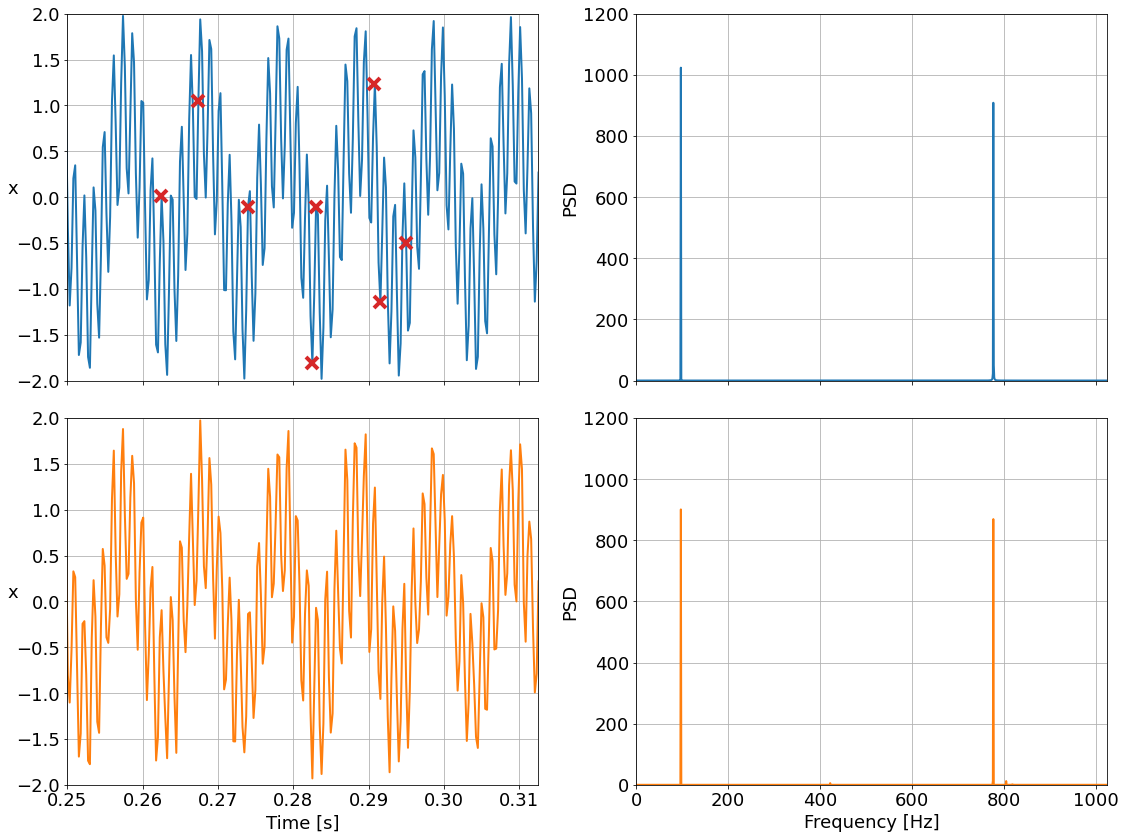

In [6]:
# Figure 3.8

time_window = np.array([1024, 1280]) / 4096
freq = np.arange(n)
L = n // 2

fig, axs = plt.subplots(2, 2, sharex='col', sharey='col', figsize=(16, 12))
axs = axs.ravel()

axs[0].plot(t, x, color='C0', linewidth=2)
axs[0].plot(subset_indices / n, y, color='C3', marker='x', linewidth=0, ms=12, mew=4)
axs[0].set_xlim(time_window[0], time_window[1])
axs[0].set_ylim(-2, 2)
axs[0].set_ylabel('x', rotation=0)
axs[0].grid(True)

axs[1].plot(freq[:L], PSD[:L], color='C0', linewidth=2)
axs[1].set_xlim(0, 1024)
axs[1].set_ylim(0, 1200)
axs[1].set_ylabel('PSD')
axs[1].grid(True)

axs[2].plot(t, xrecon, color='C1', linewidth=2)
axs[2].set_ylabel('x', rotation=0)
axs[2].set_xlabel('Time [s]')
axs[2].grid(True)


axs[3].plot(freq[:L], PSDrecon[:L], color='C1', linewidth=2)
axs[3].set_ylabel('PSD')
axs[3].set_xlabel('Frequency [Hz]')
axs[3].grid(True)
plt.tight_layout()

In [7]:
# Alternative L1-Minimization method using https://www.cvxpy.org/
import cvxpy as cp

s = cp.Variable(n)
cp.Problem(
    cp.Minimize(cp.norm1(s)),
    [Θ @ s == y]
).solve()
s = s.value

scale = s.sum()
s[np.argpartition(s, -10)[:-10]] = 0
s *= scale / s.sum()

# Reconstruct full signal from components
xrecon = idct(s)

# Power spectral density
PSDrecon = abs(fft(xrecon))**2 / n

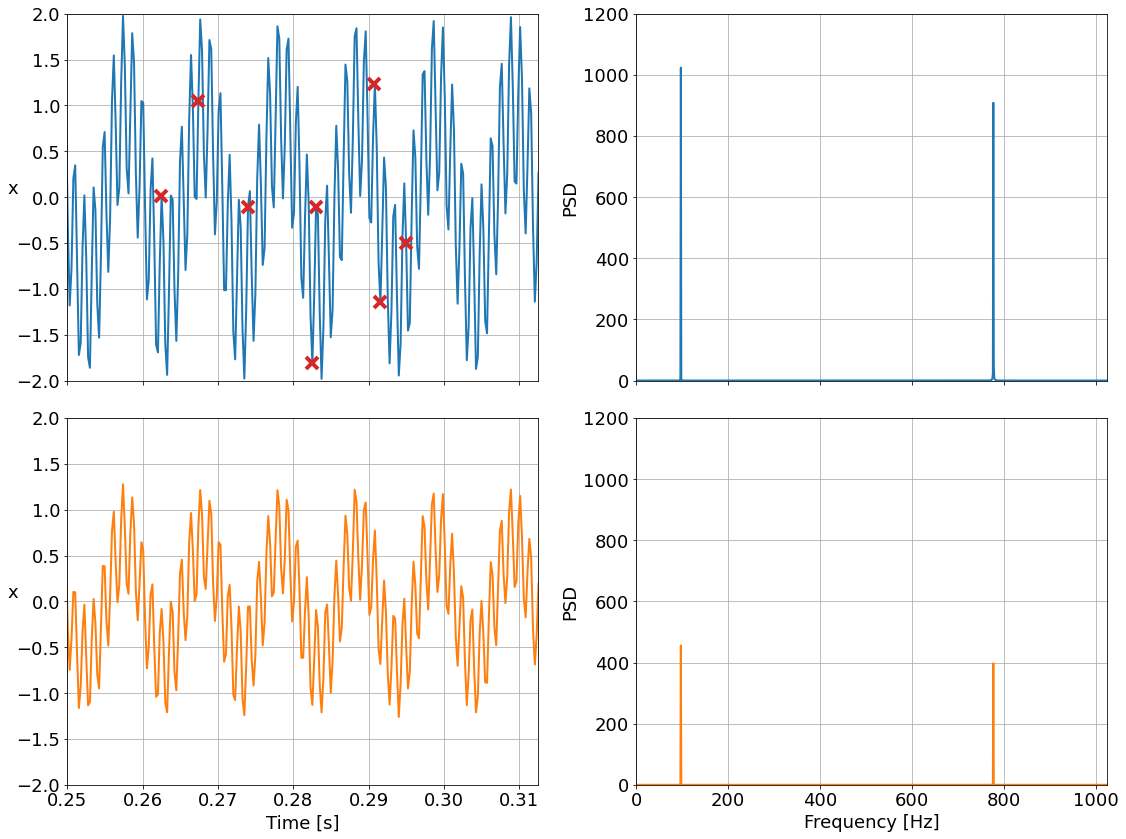

In [8]:
# Figure 3.8 (alternative method)

time_window = np.array([1024, 1280]) / 4096
freq = np.arange(n)
L = n // 2

fig, axs = plt.subplots(2, 2, sharex='col', sharey='col', figsize=(16, 12))
axs = axs.ravel()

axs[0].plot(t, x, color='C0', linewidth=2)
axs[0].plot(subset_indices / n, y, color='C3', marker='x', linewidth=0, ms=12, mew=4)
axs[0].set_xlim(time_window[0], time_window[1])
axs[0].set_ylim(-2, 2)
axs[0].set_ylabel('x', rotation=0)
axs[0].grid(True)

axs[1].plot(freq[:L], PSD[:L], color='C0', linewidth=2)
axs[1].set_xlim(0, 1024)
axs[1].set_ylim(0, 1200)
axs[1].set_ylabel('PSD')
axs[1].grid(True)

axs[2].plot(t, xrecon, color='C1', linewidth=2)
axs[2].set_ylabel('x', rotation=0)
axs[2].set_xlabel('Time [s]')
axs[2].grid(True)


axs[3].plot(freq[:L], PSDrecon[:L], color='C1', linewidth=2)
axs[3].set_ylabel('PSD')
axs[3].set_xlabel('Frequency [Hz]')
axs[3].grid(True)
plt.tight_layout()